In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib, pickle, gc
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random
from collections import Counter
# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


## Load data

In [2]:
# filename = 'Datasets/final_imit_spec.pkl'
# filename = 'Datasets/final_imit_spec2_128.pkl'
filename = 'Datasets/revision_imit_mti_spec2_128_last.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
imit_train_images, imit_test_images, imit_y_train, imit_y_test, imit_env_train, imit_env_test = [x[0], x[1]
                                                                                                , x[2], x[3]
                                                                                                , x[4], x[5]]
print(imit_train_images.shape)
print(imit_test_images.shape)
print(imit_y_train.shape)
print(imit_y_test.shape)
print(imit_env_train.shape)
print(imit_env_test.shape)

(800, 120, 128, 128, 3)
(200, 120, 128, 128, 3)
(800, 120, 19)
(200, 120, 19)
(800,)
(200,)


In [3]:
filename = 'Datasets/revision_mti_mask_imit.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
mask_train_raw, mask_test_raw = [x[0], x[1]]
print(mask_train_raw.shape)
print(mask_test_raw.shape)

(800, 1482)
(200, 1482)


In [4]:
def dbd(mask_raw,threshold,fill_gap): # dynamic boundary detection
    mask = mask_raw > threshold 
    
    for i in range(mask.shape[0]):
        cnt = 1
        for j in range(1,mask.shape[1]):
            if mask[i,j-1] == False and mask[i,j] == False:
                cnt += 1
                continue
            if mask[i,j-1] == False and mask[i,j] == True:
                if cnt < fill_gap:
                    mask[i,j-cnt:j] = True
                cnt = 1
            if mask[i,j-1] == True:
                cnt = 1
    return mask

In [5]:
threshold = 61 # 50
fill_gap = 100 # 100
mask_train = dbd(mask_train_raw,threshold,fill_gap)
mask_test = dbd(mask_test_raw,threshold,fill_gap)

In [6]:
# timevec = np.linspace(0,24.2,mask_train_raw.shape[1])
# idx = 3
# plt.plot(timevec,imit_env_test[idx]/max(imit_env_test[idx]),color='black')
# plt.plot(timevec,mask_test[idx],linewidth=3,color='red')
# plt.legend(['Euclidean Distance','DBD Detector'], loc = 'upper right', fontsize = 'xx-large')
# fig = plt.gcf()
# fig.set_size_inches(12,6)
# plt.xticks(fontsize=19)
# plt.yticks(fontsize=19)
# plt.xlabel('Time (sec)',fontsize=19, fontname='Comic Sans MS')
# plt.ylabel('Normalized Euclidean Distance',fontsize=19)
# # plt.savefig(str(idx)+' dbd gesture detect.png',dpi=400)

In [7]:
def gesture_counter(mask):
    cnt = 0
    flag = 0
    for i in range(len(mask)):
        if flag == 0 and mask[i] == 0:
            continue
        if flag == 1 and mask[i] == 1:
            continue
        if flag == 0 and mask[i] == 1:
            flag = 1
            cnt += 1
        if flag == 1 and mask[i] == 0:
            flag = 0
    return cnt

In [8]:
numgest = [gesture_counter(m) for m in mask_test]
sum(numgest)

685

In [9]:
num_class = 19

In [10]:
def masker(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [11]:
def down_mask(mask, des_len):
    return np.array([mask[int(len(mask)/des_len*i)] for i in range(des_len)])

In [12]:
des_len = imit_train_images.shape[1]
mask_down_train = np.array([down_mask(mask, des_len) for mask in mask_train])
mask_down_test = np.array([down_mask(mask, des_len) for mask in mask_test])
y_down_train = np.array([down_mask(y, des_len) for y in imit_y_train])
y_down_test = np.array([down_mask(y, des_len) for y in imit_y_test])
y_down_train_cat = to_categorical(y_down_train, num_classes=num_class)
y_down_test_cat = to_categorical(y_down_test, num_classes=num_class)
print(mask_down_train.shape)
print(mask_down_test.shape)
print(y_down_train.shape)
print(y_down_test.shape)
print(y_down_train_cat.shape)
print(y_down_test_cat.shape)

(800, 120)
(200, 120)
(800, 120, 19)
(200, 120, 19)
(800, 120, 19, 19)
(200, 120, 19, 19)


# Gesture detector accuracy

In [13]:
print(mask_down_train.shape)
mask_y = np.argmax(y_down_train,-1) == 0
print(mask_y.shape)
cmp = mask_y != mask_down_train
print(cmp.shape)
acc = np.sum(cmp)/(cmp.shape[0]*cmp.shape[1])*100
print(acc)

(800, 120)
(800, 120)
(800, 120)
84.17916666666667


In [14]:
# thresholds = np.linspace(1,255,255)
# acc_ls = []
# for j,v in enumerate(thresholds):
#     mask_train = dbd(mask_train_raw,v,fill_gap)
#     mask_down_train = np.array([down_mask(mask, des_len) for mask in mask_train])
#     cmp = mask_y != mask_down_train
#     acc = np.sum(cmp)/(cmp.shape[0]*cmp.shape[1])*100
#     acc_ls.append(acc)
#     print(j+1,'. Threshold:',thresholds[j],', acc:',acc)

In [15]:
# plt.figure(figsize=(6,3),dpi=300)
# plt.plot(thresholds,acc_ls,color='b',label='DBD detector')
# plt.xlabel('Threshold')
# plt.ylabel('Detection Accuracy (%)')
# plt.hlines(83.2,0,thresholds[-1],'r',label='Proposed varying length STA/LTA')
# plt.legend(loc='lower right')
# plt.savefig('results/dbd compare.png')

In [16]:
x3train, y3train = masker(imit_train_images, np.argmax(y_down_train,-1), mask_down_train)
x3test, y3test = masker(imit_test_images, np.argmax(y_down_test,-1), mask_down_test) 
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

(2105,)
(2105,)
(515,)
(515,)


In [17]:
y3train[0].shape

(59, 19)

In [18]:
classes = [stats.mode(np.argmax(y,-1))[0] for y in y3train]
c = [int(x) for x in classes]
Counter(c)

Counter({1: 115,
         11: 122,
         12: 125,
         3: 645,
         5: 124,
         6: 130,
         17: 103,
         18: 111,
         8: 125,
         9: 128,
         0: 116,
         4: 13,
         14: 91,
         15: 90,
         16: 18,
         10: 19,
         13: 7,
         7: 11,
         2: 12})

In [19]:
# eliminate zeros md
x6train = np.array([x3train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
y6train = np.array([y3train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x6test = np.array([x3test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
y6test = np.array([y3test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(x6train.shape)
print(y6train.shape)
print(x6test.shape)
print(y6test.shape)

(1989,)
(1989,)
(489,)
(489,)


## RD - RA

In [20]:
# filename = 'Datasets/final_imit_RD-RA2.pkl'
# with open(filename, 'rb') as input:
#     x = pickle.load(input)
# imit_y_train_RD, imit_y_test_RD, imit_RD_train, imit_RA_train, imit_RD_test, imit_RA_test = [x[0], x[1]
#                                                                                                 , x[2], x[3]
#                                                                                                 , x[4], x[5]]
# print(imit_y_train_RD.shape)
# print(imit_y_test_RD.shape)
# print(imit_RD_train.shape)
# print(imit_RA_train.shape)
# print(imit_RD_test.shape)
# print(imit_RA_test.shape)
# del x

In [21]:
filename = 'Datasets/final_imit_RD-RA2_128_last.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
imit_RD_train = np.array(data["train_RD"])
imit_RA_train = np.array(data["train_RA"])
imit_RD_test = np.array(data["test_RD"])
imit_RA_test = np.array(data["test_RA"])
data.close()
print(imit_RD_train.shape)
print(imit_RA_train.shape)
print(imit_RD_test.shape)
print(imit_RA_test.shape)

Selected File: Datasets/final_imit_RD-RA2_128_last.hdf5
(800, 605, 128, 128, 3)
(800, 605, 128, 128, 3)
(200, 605, 128, 128, 3)
(200, 605, 128, 128, 3)


In [22]:
# windowed RD
interval = range(0,600)
x_train11 = np.reshape(imit_RD_train[:,interval,:,:,:], (imit_RD_train.shape[0],120,5,imit_RD_train.shape[2],imit_RD_train.shape[3],imit_RD_train.shape[4]))
x_test11 = np.reshape(imit_RD_test[:,interval,:,:,:], (imit_RD_test.shape[0],120,5,imit_RD_test.shape[2],imit_RD_test.shape[3],imit_RD_test.shape[4]))
# y_train11 = np.reshape(imit_y_train_RD[:,interval], (imit_y_train_RD.shape[0],120,5))
# y_test11 = np.reshape(imit_y_test_RD[:,interval], (imit_y_test_RD.shape[0],120,5))
# y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
# y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
# print(y_train11.shape)
print(x_test11.shape)
# print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(imit_RA_train[:,interval,:,:,:], (imit_RA_train.shape[0],120,5,imit_RA_train.shape[2],imit_RA_train.shape[3],imit_RA_train.shape[4]))
x_test12 = np.reshape(imit_RA_test[:,interval,:,:,:], (imit_RA_test.shape[0],120,5,imit_RA_test.shape[2],imit_RA_test.shape[3],imit_RA_test.shape[4]))
print(x_train12.shape)
print(x_test12.shape)

(800, 120, 5, 128, 128, 3)
(200, 120, 5, 128, 128, 3)
(800, 120, 5, 128, 128, 3)
(200, 120, 5, 128, 128, 3)


In [23]:
# x1train, y1train = masker(x_train11, np.argmax(y_train11,-1), mask_down_train)
# x1test, y1test = masker(x_test11, np.argmax(y_test11,-1), mask_down_test)
# x2train, y1train = masker(x_train12, np.argmax(y_train11,-1), mask_down_train)
# x2test, y1test = masker(x_test12, np.argmax(y_test11,-1), mask_down_test)
x1train, y1train = masker(x_train11, y_down_train, mask_down_train)
x1test, y1test = masker(x_test11, y_down_test, mask_down_test)
x2train, y1train = masker(x_train12, y_down_train, mask_down_train)
x2test, y1test = masker(x_test12, y_down_test, mask_down_test)
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)
print(x2train.shape)
print(x2test.shape)

(2105,)
(2105,)
(515,)
(515,)
(2105,)
(515,)


In [24]:
x10train = np.array([x1train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x11train = np.array([x2train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
# y10train = np.array([y1train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x10test = np.array([x1test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
x11test = np.array([x2test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
# y10test = np.array([y1test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(x10train.shape)
# print(y10train.shape)
print(x10test.shape)
# print(y10test.shape)
print(x11train.shape)
print(x11test.shape)

(1989,)
(489,)
(1989,)
(489,)


In [25]:
x12train = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x10train])
x13train = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x11train])
x12test = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x10test])
x13test = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x11test])
print(x12train[0].shape)
print(x12test[0].shape)
print(x13train.shape)
print(x13test.shape)

(295, 128, 128, 3)
(235, 128, 128, 3)
(1989,)
(489,)


In [26]:
input_shape_vid = (None, x_train11[0].shape[1],x_train11[0].shape[2],x_train11[0].shape[3],x_train11[0].shape[4])
print('Input shape of f-b-f RD: ',input_shape_vid)

Input shape of f-b-f RD:  (None, 5, 128, 128, 3)


In [27]:
input_shape11 = (None,x3train[0].shape[1],x3train[0].shape[2],x3train[0].shape[3])
print('Input shape of f-b-f mD: ',input_shape11)

Input shape of f-b-f mD:  (None, 128, 128, 3)


In [28]:
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=early_stopping_patience, restore_best_weights=True
)

In [29]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.5, patience=0, verbose=0)

In [30]:
gc.collect()

249

In [31]:
ytrain = np.array([np.squeeze(to_categorical(stats.mode(np.argmax(y3train[i],-1))[0],19)) for i in tqdm(range(len(y3train)), position = 0, leave = True) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
ytest = np.array([np.squeeze(to_categorical(stats.mode(np.argmax(y3test[i],-1))[0],19)) for i in tqdm(range(len(y3test)), position = 0, leave = True) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(ytrain.shape)
print(ytest.shape)

100%|██████████| 515/515 [00:00<00:00, 2913.64it/s]

(1989, 19)
(489, 19)


In [32]:
def mode_finder(y): # finds the mode that is not zero
    y = np.argmax(y,-1)
    mode = stats.mode(y)[0]
    if mode == 0:
        mask = y == mode
        y = y[~np.ma.masked_array(y, mask = mask).mask]
        new_mode = stats.mode(y)[0]
    else:
        new_mode = mode
    return np.squeeze(new_mode)

## Model

In [33]:
def data_generator(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(label[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train, y_train

In [34]:
def data_generator_pred(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(label[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train

### micro-Doppler

In [35]:
def tdcnn2d_bilstm_seq(input_shapex):
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shapex)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer1)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Flatten())(x)

#         x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer1)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
# #         x = BatchNormalization()(x)
#         x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
# #         x = BatchNormalization()(x)
#         x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(x)
#         x = TimeDistributed(Flatten())(x)

#         x = Reshape(target_shape = (-1,64*8*8))(x)
#         x = Dropout(0.5)(x)
#         x = Bidirectional(LSTM(8, dropout=0.5, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(x)
#         x = Dropout(0.5)(x)
        out1 = Dense(num_class,activation='softmax')(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
        return model 

In [36]:
model = tdcnn2d_bilstm_seq(input_shape11)
# model.summary()

In [37]:
train_dataset = data_generator(x6train, y6train)
validation_dataset = data_generator(x6test, y6test)

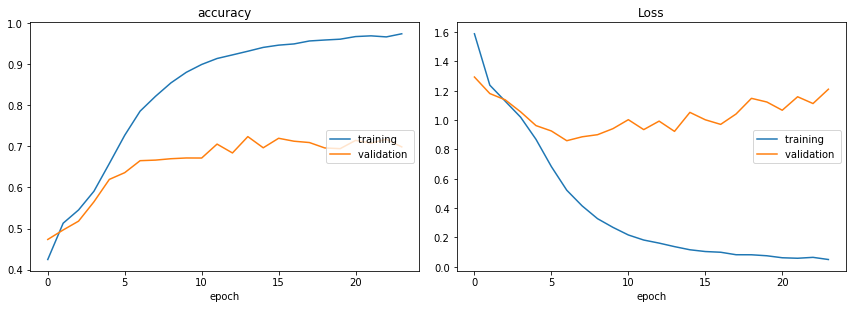

accuracy
	training         	 (min:    0.425, max:    0.974, cur:    0.974)
	validation       	 (min:    0.473, max:    0.724, cur:    0.699)
Loss
	training         	 (min:    0.050, max:    1.589, cur:    0.050)
	validation       	 (min:    0.860, max:    1.294, cur:    1.211)
1989/1989 [==============================] - 28s 14ms/step - loss: 0.0499 - accuracy: 0.9740 - val_loss: 1.2111 - val_accuracy: 0.6987


In [38]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(y6train), validation_steps = len(y6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [39]:
# save model
fname = 'revdbd md gd td2d'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [40]:
loss, acc = model.evaluate(validation_dataset, steps = len(y6test))
loss, acc

489/489 [==============================] - 3s 7ms/step - loss: 0.9236 - accuracy: 0.7238


(0.9235566854476929, 0.7237561345100403)

In [41]:
# testing duration
import time
def loadmodel(fname):
    model_file = 'Models/' + fname + '.json'
    w_file = 'Models/' + fname + '.h5'
    json_file = open(model_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_md = model_from_json(loaded_model_json)
    model_md.load_weights(w_file)
    return model_md

In [42]:
mod_md = loadmodel('revdbd md gd td2d')
validation_dataset = data_generator_pred(x6test, y6test)
t = time.time()
p = [np.squeeze(mod_md.predict(next(validation_dataset))) for i in range(len(y6test))]
time.time() - t

27.043257236480713

In [43]:
from tqdm import tqdm

In [44]:
mod_md = loadmodel('revdbd md gd td2d')
validation_dataset = data_generator_pred(x6test, y6test)
elapsed_md = []
for i in tqdm(range(50),position=0):
    t = time.time()
    p = [np.squeeze(mod_md.predict(next(validation_dataset))) for i in range(len(y6test))]
    elapsed_md.append(time.time() - t)
np.mean(elapsed_md)

100%|██████████| 50/50 [21:31<00:00, 25.82s/it]


25.8182826423645

### RD

In [45]:
def tdcnn3d_bilstm_seq(input_shapex):
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shapex)
        x = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer1)
        x = TimeDistributed(MaxPooling3D(pool_size=(1, 2, 2)))(x)
        x = TimeDistributed(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1, 2, 2)))(x)
        x = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1, 2, 2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1, 2, 2)))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1, 4, 1)))(x)
        x = TimeDistributed(Flatten())(x)
#         x = Reshape(target_shape = (-1, 64*8*8*5))(x)
        x = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(x)
        
        out1 = Dense(num_class,activation='softmax')(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
        return model 

In [46]:
def tdcnn2d_bilstm_seq_vid(input_shapex):
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shapex)

        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer1)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
#         x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(Flatten())(x)

        x = Reshape(target_shape = (-1,32*16*16*5))(x)
#         x = Dropout(0.5)(x)
#         x = Bidirectional(LSTM(8, dropout=0.5, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(x)
#         x = Dropout(0.5)(x)
        out1 = Dense(num_class,activation='softmax')(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
        return model 

In [47]:
# model = tdcnn3d_bilstm_seq(input_shape_vid)
model = tdcnn2d_bilstm_seq_vid(input_shape11)

In [48]:
train_dataset = data_generator(x12train, y6train) # x10train
validation_dataset = data_generator(x12test, y6test) # x10test

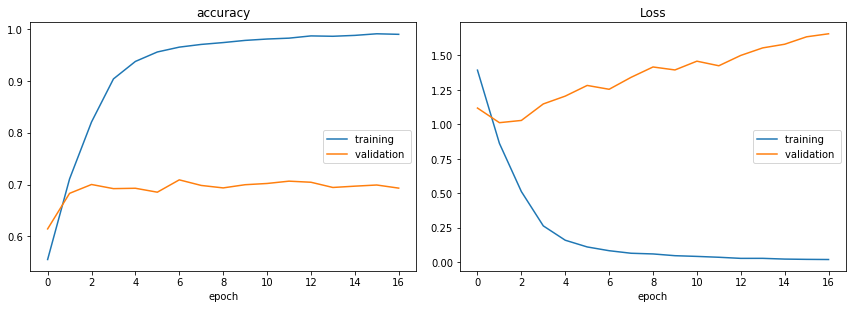

accuracy
	training         	 (min:    0.425, max:    0.991, cur:    0.990)
	validation       	 (min:    0.473, max:    0.724, cur:    0.693)
Loss
	training         	 (min:    0.020, max:    1.589, cur:    0.020)
	validation       	 (min:    0.860, max:    1.657, cur:    1.657)
1989/1989 [==============================] - 32s 16ms/step - loss: 0.0197 - accuracy: 0.9901 - val_loss: 1.6570 - val_accuracy: 0.6931


In [49]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(y6train), validation_steps = len(y6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [50]:
# save model
fname = 'revdbd rd gd td2d'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [51]:
loss, acc = model.evaluate(validation_dataset, steps = len(y6test))
loss, acc # 56.9

489/489 [==============================] - 3s 7ms/step - loss: 1.2545 - accuracy: 0.7090


(1.2544714212417603, 0.7090399265289307)

In [52]:
x10train[0].shape

(59, 5, 128, 128, 3)

In [53]:
def loadmodel(fname):
    model_file = 'Models/' + fname + '.json'
    w_file = 'Models/' + fname + '.h5'
    json_file = open(model_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_md = model_from_json(loaded_model_json)
    model_md.load_weights(w_file)
    return model_md

In [54]:
import time

In [56]:
mod_rd = loadmodel('revdbd rd gd td2d')
validation_dataset = data_generator_pred(x12test, y6test)
elapsed_rd = []
for i in range(1):
    t = time.time()
    p = [np.squeeze(mod_rd.predict(next(validation_dataset))) for i in range(len(y6test))]
    elapsed_rd.append(time.time() - t)
np.mean(elapsed_rd)

27.88324213027954

### RA

In [57]:
model = tdcnn2d_bilstm_seq_vid(input_shape11)

In [58]:
train_dataset = data_generator(x13train, y6train)
validation_dataset = data_generator(x13test, y6test)

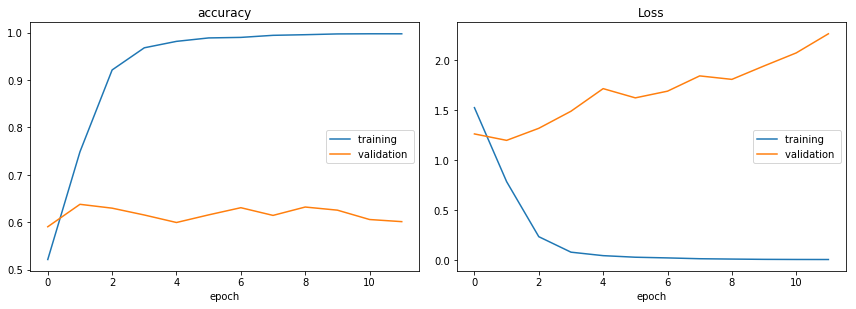

accuracy
	training         	 (min:    0.425, max:    0.998, cur:    0.998)
	validation       	 (min:    0.473, max:    0.724, cur:    0.601)
Loss
	training         	 (min:    0.005, max:    1.589, cur:    0.005)
	validation       	 (min:    0.860, max:    2.264, cur:    2.264)
1989/1989 [==============================] - 34s 17ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 2.2642 - val_accuracy: 0.6011


In [59]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(y6train), validation_steps = len(y6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [60]:
# save model
fname = 'revdbd ra gd td2d'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [61]:
loss, acc = model.evaluate(validation_dataset, steps = len(y6test))
loss, acc

489/489 [==============================] - 3s 7ms/step - loss: 1.1975 - accuracy: 0.6377


(1.1974557638168335, 0.6377014517784119)

In [62]:
mod_ra = loadmodel('revdbd ra gd td2d')
validation_dataset = data_generator_pred(x13test, y6test)
elapsed_ra = []
for i in range(1):
    t = time.time()
    p = [np.squeeze(mod_ra.predict(next(validation_dataset))) for i in range(len(y6test))]
    elapsed_ra.append(time.time() - t)
np.mean(elapsed_ra)

31.25806975364685